In [1]:
import cv2
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from instrumental.drivers.cameras import uc480


import matplotlib.pyplot as plt
import math
from PIL import Image

import scipy.fftpack as sfft
import random
import sys
from pylab import *
from mpl_toolkits.mplot3d import Axes3D

from scipy.ndimage import label, center_of_mass
import cv2
import tifffile
from scipy.spatial import ConvexHull
from scipy.special import comb, factorial

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

### 1920 x 1200 SLM


In [2]:

def Ger_Sax_algo(InputImg, width, height, max_iter):
    TwoDImg = np.reshape(InputImg, (-1, width))

    pm_s = np.random.rand(height, width)
    pm_f = np.ones((height, width))
    am_s = np.sqrt(TwoDImg) / 2
    am_f = np.ones((height, width))

    signal_s = am_s*np.exp(pm_s * 1j)

    for iter in range(max_iter):
        signal_f = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(signal_s)))
        pm_f = np.angle(signal_f)
        signal_f = am_f*np.exp(pm_f * 1j)
        signal_s = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(signal_f)))
        pm_s = np.angle(signal_s)
        signal_s = am_s*np.exp(pm_s * 1j)

    phase_mask = np.uint8(((pm_f/(2*np.pi))*256)+128)
    ### flat_phase = phase_mask.flatten()

    return phase_mask

### SLM Direct Images
# Create an SLM grating with sinusoidal pixel values

def gen_tweezers(xrad, yrad, xspacing, yspacing, xmin, xmax, ymin,ymax):
    simplegrating = np.zeros(np.shape(blank))

    for i in range(xmin,xmax):
        for j in range(ymin,ymax):
            pixcoord = 0
            distj1 = j  % yspacing
            disti1 = i  % xspacing
            distj2 = (yspacing - j) % yspacing
            disti2 = (xspacing - i) % xspacing
            distj = min((distj1, distj2))
            disti = min((disti1, disti2))
            if (distj < xrad) and (disti < yrad):
                pixcoord = 255
            simplegrating[j,i] = pixcoord
    return simplegrating


def gaussian_distribution(x, radius):
    return np.exp(-0.5 * (x / radius)**2)

def gen_tweezers_precise(xrad, yrad, xspacing, yspacing, xstart, xend, ystart,yend):
    simplegrating = np.zeros(np.shape(blank))
    
    for i in range(xstart, xend):
        for j in range(ystart,yend):
            pixcoord = 0
            distj1 = (j - ystart)  % yspacing
            disti1 = (i - xstart) % xspacing
            distj2 = (yspacing - (j-ystart)) % yspacing
            disti2 = (xspacing - (i-xstart)) % xspacing
            distj = min((distj1, distj2))
            disti = min((disti1, disti2))
            if (distj < xrad) and (disti < yrad):
                pixcoord = 255
            simplegrating[j,i] = pixcoord
    return simplegrating

def gaussian_tweezers_precise(xrad, yrad, xspacing, yspacing, xstart, xend, ystart,yend, radius):
    tweezers = gen_tweezers_precise(xrad, yrad, xspacing, yspacing, xstart, xend, ystart,yend)
    gaussiantweezers = tweezers
    binary_camera_image = (tweezers > 2).astype(np.uint8)
    labeled_camera_image, num_labels_camera = label(binary_camera_image)
    centers_camera = np.array(center_of_mass(binary_camera_image, labeled_camera_image, range(1, num_labels_camera + 1)))
    ## Capture 99.7% of the distribution
    factor = 3
    for i in range(len(centers_camera)):
        for x in range(-radius, radius,1):
            for y in range(-radius, radius,1):
                
                radvalue = (x**2+y**2)**0.5
                if radvalue < radius:
                    gaussiantweezers[centers_camera[i][0].astype(np.int) + x, centers_camera[i][1].astype(np.int) + y] += 255*gaussian_distribution(radvalue * 3, radius)
    
    return gaussiantweezers

def gen_circlemask(radius):
    simplegrating = np.zeros(np.shape(blank))
    for i in range(1920 * precision):
        for j in range(1200 * precision):
            pixcoord = 0
            if (((1920 * precision)/2 - i)**2 + ((1200 * precision)/2 - j)**2)**0.5 < radius:
                pixcoord = 255
            simplegrating[i,j] = pixcoord
    return simplegrating


### Image writing!

def f_grating(pattern):
    return Ger_Sax_algo(pattern, numcols, numrows, max_iter)

def writeimg(array, name):
    data = Image.fromarray(array).convert('RGB')
    data.save(name+".bmp")
    return print(name+" saved succesfully.")

def print_1Dimgs(function, numframes, min_width_pix, stepsize_pix):
    width = min_width_pix
    for i in range(numframes):
        name = str(100+i)
        array = function(width)
        writeimg(array, name)
        width += stepsize_pix
    return print("Image writing successful.")

def print_2Dimgs(function, numframes, min_width_pix, min_length_pix, stepsize_w_pix, stepsize_l_pix):
    width = min_width_pix
    length = min_length_pix
    for i in range(numframes):
        name = str(100+i)
        array = function(width, length)
        writeimg(array, name)
        width += stepsize_w_pix
        length += stepsize_l_pix
    return print("Image writing successful.")

def print_f_1Dimgs(function, numframes, min_width_pix, stepsize_pix):
    width = min_width_pix
    for i in range(numframes):
        name = str(100+i)
        array = function(width)
        farray = f_grating(array)
        writeimg(farray, name)
        width += stepsize_pix
    return print("Image writing successful.")

def print_f_2Dimgs(function, numframes, min_width_pix, min_length_pix, stepsize_w_pix, stepsize_l_pix):
    width = min_width_pix
    length = min_length_pix
    for i in range(numframes):
        name = str(100+i)
        array = function(width, length)
        farray = f_grating(array)
        writeimg(farray, name)
        width += stepsize_w_pix
        length += stepsize_l_pix
    return print("Image writing successful.")


def slm_2D_simulator(function, maxiter, min_width_pix, min_length_pix):
    slmarray = function(min_width_pix, min_length_pix)
    slmimage = Ger_Sax_algo(slmarray, numcols, numrows, maxiter)
    fourierimage = np.abs(np.fft.fft2(slmimage))
    fourierimage = fourierimage/np.max(fourierimage)*255
    writeimg(fourierimage,"simulim")
    return print("Print successful")


### Optimization code
### Testing Ger-Sax algorithm

def epsilon(u_int, target_im):
    max = np.max(u_int[target_im!=0]) #Max value of the obtained intensity at the tweezers position
    min = np.min(u_int[target_im!=0]) #Min value of the obtained intensity at the tweezers position
    error = (max-min)/(max+min)
    
    # error = np.sum(np.abs(u_int-target_im))
    #print("Error :", error)
    return error

def epsilon_gaussian(u_int, target_im):
    max = np.max(u_int[target_im!=0]) #Max value of the obtained intensity at the tweezers position
    min = np.min(u_int[target_im!=0]) #Min value of the obtained intensity at the tweezers position
    error = (max-min)/(max+min)
    
    # error = np.sum(np.abs(u_int-target_im))
    #print("Error :", error)
    return error


def join_phase_ampl(phase,ampl):
    tmp=np.zeros((ampl.shape[0],ampl.shape[1]),dtype=complex)
    tmp = ampl*np.exp(phase*1j)
    return tmp

def Beam_shape(sizex,sizey,sigma,mu):
    x, y = np.meshgrid(np.linspace(-1,1,sizex), np.linspace(-1,1,sizey))
    d = np.sqrt(x*x+y*y)
    g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
    return g

def surface_plot (matrix, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    return (fig, ax, surf)

def norm(matrix):
    min=np.min(matrix);max=np.max(matrix)
    return((matrix-min)/(max-min))

def bin_norm_clip(matrix):  # Function that clips the values to 0-255 (SLM standard)
    matrix=np.array(target_im, dtype=np.uint8)
    matrix=norm(matrix)
    return(matrix)


def screwone(list):
    for number in list:
        if number == 1:
            number = number - 0.01
    return number

def weights(w,target_im,w_prev,std_int): # This weight function works only where the intensity == 1 (discrete tweezers)
    # targetmatch_indices = np.argwhere(target_im==1)
    # for i in targetmatch_indices:
    #     for x in range(-2,3):
    #         for y in range(-2,3):
    #             w[i[0]+x,i[1]+y] = np.sqrt((target_im[i[0]+x,i[1]+y] / std_int[i[0]+x,i[1]+y])) *w_prev[i[0]+x,i[1]+y]
    #             # w[target_im!=1] = np.sqrt(1 / (1-screwone(std_int[target_im!=1]))) * w_prev[target_im!=1]
    w[target_im==1] = np.sqrt((target_im[target_im==1] / std_int[target_im==1])) * w_prev[target_im==1]
    return (w)

def weights_gaussian(w,target_im,w_prev,std_int): # This weight function works only where the intensity == 1 (discrete tweezers)
    # targetmatch_indices = np.argwhere(target_im==1)
    # for i in targetmatch_indices:
    #     for x in range(-2,3):
    #         for y in range(-2,3):
    #             w[i[0]+x,i[1]+y] = np.sqrt((target_im[i[0]+x,i[1]+y] / std_int[i[0]+x,i[1]+y])) *w_prev[i[0]+x,i[1]+y]
    #             # w[target_im!=1] = np.sqrt(1 / (1-screwone(std_int[target_im!=1]))) * w_prev[target_im!=1]
    w[target_im!=0] = np.sqrt((target_im[target_im!=0] / std_int[target_im!=0])) * w_prev[target_im!=0]
    return (w)

def weightintensity_lukin(target, target_prev, std_int, target_im):
    target[target_im==1] = np.sqrt((np.mean(std_int[target_im==1]) / (std_int[target_im==1]+0.001))) * target_prev[target_im==1]
    return target


# def screwone(list):
#     for number in list:
#         if number == 1:
#             number = number - 0.001
#     return number

# def weights(w,target_im,w_prev,std_int): # This weight function works only where the intensity == 1 (discrete tweezers)
#     w[target_im==1] = np.sqrt((target_im[target_im==1] / std_int[target_im==1])) * w_prev[target_im==1]
#     w[target_im!=1] = np.sqrt(1 / (1-screwone(std_int[target_im!=1]))) * w_prev[target_im!=1]

#     return (w)


def discretize_phase(phase):
    phase=np.round((phase+np.pi)*255/(2*np.pi))
    return(phase)

def undiscretize_phase(phase):
    phase=phase/255*(2*np.pi)-np.pi
    return(phase)

def set_circlemask(inputmatrix, radius):
    image = inputmatrix
    image[np.sqrt((np.arange(image.shape[0])[:,None] - image.shape[0]//2)**2 + (np.arange(image.shape[1]) - image.shape[1]//2)**2) > radius] = 0
  
    return image


def identify_tweezers(cameraimage, minintensity):
    ## This code assumes that the camera image is positioned s.t. the 0th order diffraction is centered vertically and just out of screen
    binary_camera_image = (cameraimage > minintensity).astype(np.uint8)
    labeled_camera_image, num_labels_camera = label(binary_camera_image)
    centers_camera = np.array(center_of_mass(binary_camera_image, labeled_camera_image, range(1, num_labels_camera + 1)))
    sorted_centers = centers_camera[np.lexsort((centers_camera[:, 1], centers_camera[:, 0]))]


    center = np.median(sorted_centers, axis=0)
    distances = np.linalg.norm(sorted_centers - center, axis=1)
    indices = np.argsort(distances)[-4:]
    corners = sorted_centers[indices]
    
    # perimeter = ConvexHull(sorted_centers) 
    # corners = sorted_centers[perimeter.vertices]
    return corners[np.argsort(corners[:,0])], center

from scipy.ndimage import affine_transform

def rotate_image(image, angle):
    # Calculate the rotation matrix
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle), np.cos(angle)]])

    # Calculate the translation needed to reposition the rotated image
    center = np.array(image.shape) // 2
    translation = center - np.dot(rotation_matrix, center)

    # Define the affine transformation matrix
    transformation_matrix = np.vstack([np.column_stack([rotation_matrix, translation]),
                                       [0, 0, 1]])

    # Apply the affine transformation to rotate the image
    rotated_image = affine_transform(image, transformation_matrix, mode='constant', cval=0)

    return rotated_image

from scipy.ndimage import zoom

def match_images(cameraimage, targetimage, intensity):
    camera_vertices = identify_tweezers(cameraimage, intensity)[0]
    angle = math.atan((camera_vertices[1,0]-camera_vertices[0,0])/(camera_vertices[1,1]-camera_vertices[0,1]))
    rotated_cameraimage = rotate_image(cameraimage, -angle)
    rotated_cameraimage_vertices = identify_tweezers(rotated_cameraimage, intensity)[0]
    targetimage_vertices, targetimage_center = identify_tweezers(targetimage, 1)

    height_target_rect = np.abs(targetimage_vertices[0,0] - targetimage_vertices[2,0])
    width_target_rect = np.abs(targetimage_vertices[0,1] - targetimage_vertices[1,1])
    height_camera_rect = np.abs(rotated_cameraimage_vertices[0,0] - rotated_cameraimage_vertices[2,0])
    width_camera_rect = np.abs(rotated_cameraimage_vertices[0,1] - rotated_cameraimage_vertices[1,1])

    height_scaling = height_target_rect / height_camera_rect
    width_scaling = width_target_rect / width_camera_rect
 
    scaled_camera_img = zoom(rotated_cameraimage, (height_scaling,width_scaling), mode='constant', cval = 0)
    scaled_camera_img_vertices, scaled_camera_center = identify_tweezers(scaled_camera_img, intensity)
 
    
    final_camera_img = np.zeros_like(targetimage)
    
    for y in range(np.shape(scaled_camera_img)[0]):
        for x in range(np.shape(scaled_camera_img)[1]):
            final_camera_img[y+(targetimage_center[0]-scaled_camera_center[0]).astype(np.int),x+(targetimage_center[1]-scaled_camera_center[1]).astype(np.int)] = scaled_camera_img[y,x]
    return final_camera_img, -angle, height_scaling, width_scaling, (targetimage_center[0]-scaled_camera_center[0]).astype(np.int), (targetimage_center[1]-scaled_camera_center[1]).astype(np.int)


def match_images_local(cameraimage, targetimage, params, scanradius):
    cameraimage = cameraimage
    targetimage = targetimage
    angle, Xmag, Ymag, Xshift, Yshift = params
    slave9 = rotate_image(cameraimage, angle)
    slave8 = scaleimg(slave9, Xmag, Ymag)
    master = np.zeros(np.shape(targetimage))
    original = shiftimage(slave8, targetimage, Xshift, Yshift)
    error = np.abs(np.sum(targetimage-original))
    for i in range(scanradius):
        for j in range(scanradius):
            slave_shifted = shiftimage(slave8, targetimage, Xshift - scanradius/2 + i, Yshift - scanradius/2 +j)
            errortemp = np.abs(np.sum(slave_shifted-targetimage))
            if errortemp < error:
                error = errortemp
                master = slave_shifted
    if np.sum(master) == 0:
        return original
    else:
        return master

def shiftimage(child1, parent, x_shift, y_shift):
    child_shape = np.shape(child1)
    parent_shape = np.shape(parent)
    fosterparent = np.zeros(parent_shape)
    x_shift = x_shift.astype(np.int)
    y_shift = y_shift.astype(np.int)
    fosterparent[x_shift:x_shift+child_shape[0], y_shift:y_shift+child_shape[1]] = child1
    return fosterparent

def scaleimg(child2, x_scaling, y_scaling):
    scaled_child = zoom(child2, (x_scaling, y_scaling), mode='constant', cval = 0)
    return scaled_child

    
    
def objectivefunction(params, child, parent):
    angle, Xmag, Ymag, Xshift, Yshift = params
    slave = rotate_image(child, angle)
    slave = scaleimg(slave, Xmag, Ymag)
    slave = shiftimage(slave, parent, Xshift, Yshift)
    
    error = np.abs(np.sum(slave-parent))
    return error


def find_weighted_center(image):
    # Create coordinate grids
    image = norm(image)
    image[image<0.3] = 0
    
    non_zero_coords = np.transpose(np.nonzero(image))
    if non_zero_coords.shape[0] > 0:
        average_coordinates = np.mean(non_zero_coords, axis=0)
        return tuple(average_coordinates.astype(int))
    else:
        return None


from PIL import Image

def tiff_to_bmp(input_path, output_path):
    # Open TIFF image
    tiff_image = Image.open(input_path)

    # Save as BMP
    tiff_image.save(output_path, 'BMP')
    
    
import cv2
import numpy as np

def match_and_paste(parent, child):
    # Convert images to grayscale
    parent_gray = cv2.cvtColor(parent, cv2.COLOR_BGR2GRAY)
    child_gray = cv2.cvtColor(child, cv2.COLOR_BGR2GRAY)

    # Use ORB (Oriented FAST and Rotated BRIEF) to find keypoints and descriptors
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(parent_gray, None)
    kp2, des2 = orb.detectAndCompute(child_gray, None)

    # Use BFMatcher to find the best matches between the descriptors
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Sort the matches based on their distances
    matches = sorted(matches, key=lambda x: x.distance)

    # Get the best match
    best_match = matches[0]

    # Get the keypoint coordinates for the parent and child
    parent_pts = np.float32([kp1[best_match.queryIdx].pt])
    child_pts = np.float32([kp2[best_match.trainIdx].pt])

    # Find the transformation matrix (rotation and scaling)
    M, _ = cv2.estimateAffinePartial2D(child_pts, parent_pts)

    # Apply the transformation to the child image
    child_transformed = cv2.warpAffine(child, M, (parent.shape[0], parent.shape[1]))

    return child_transformed

def identify_corners(cameraimage, targetimage, intensity):
    camera_vertices = identify_tweezers(cameraimage, intensity)[0]
    angle = math.atan((camera_vertices[1,0]-camera_vertices[0,0])/(camera_vertices[1,1]-camera_vertices[0,1]))
    rotated_cameraimage = rotate_image(cameraimage, -angle)
    rotated_cameraimage_vertices = identify_tweezers(rotated_cameraimage, intensity)[0]
    targetimage_vertices, targetimage_center = identify_tweezers(targetimage, 1)

    height_target_rect = np.abs(targetimage_vertices[0,0] - targetimage_vertices[2,0])
    width_target_rect = np.abs(targetimage_vertices[0,1] - targetimage_vertices[1,1])
    height_camera_rect = np.abs(rotated_cameraimage_vertices[0,0] - rotated_cameraimage_vertices[2,0])
    width_camera_rect = np.abs(rotated_cameraimage_vertices[0,1] - rotated_cameraimage_vertices[1,1])

    height_scaling = height_target_rect / height_camera_rect
    width_scaling = width_target_rect / width_camera_rect
 
    scaled_camera_img = zoom(rotated_cameraimage, (height_scaling,width_scaling), mode='constant', cval = 0)
    scaled_camera_img_vertices, scaled_camera_center = identify_tweezers(scaled_camera_img, intensity)
 
    
    corners_cameraimg = np.zeros_like(targetimage)
    # corners_cameraimg[int(targetimage_vertices[0,0]), int(targetimage_vertices[0,1])] = 255
    # corners_cameraimg[int(targetimage_vertices[1,0]), int(targetimage_vertices[1,1])] = 255
    # corners_cameraimg[int(targetimage_vertices[2,0]),int(targetimage_vertices[2,1])] = 255
    # corners_cameraimg[int(targetimage_vertices[3,0]),int(targetimage_vertices[3,1])] = 255
    corners_cameraimg[targetimage_vertices[0,0].astype(np.int), targetimage_vertices[0,1].astype(np.int)] = 255
    corners_cameraimg[targetimage_vertices[1,0].astype(np.int), targetimage_vertices[1,1].astype(np.int)] = 255
    corners_cameraimg[targetimage_vertices[2,0].astype(np.int),targetimage_vertices[2,1].astype(np.int)] = 255
    corners_cameraimg[targetimage_vertices[3,0].astype(np.int),targetimage_vertices[3,1].astype(np.int)] = 255
    return corners_cameraimg, -angle, height_scaling, width_scaling, (targetimage_center[0]-scaled_camera_center[0]).astype(np.int), (targetimage_center[1]-scaled_camera_center[1]).astype(np.int)

def fourier(intensity, phase):
    combintandphase = join_phase_ampl(phase, intensity)
    fft = sfft.fftshift(sfft.fft2(combintandphase))
    fft_phase = np.angle(fft)
    fft_int=np.square(np.abs(fft))
    fft_int = (fft_int) / np.max(fft_int)
    return fft_int, fft_phase


import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import sawtooth
from scipy.ndimage import rotate
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

def optimizespacing(k, theta):
    #get single-axis spacings
    d = k / np.cos(radians(theta))
    delta_d = np.random.rand(*d.shape) * np.pi
    sum = 0
    for i in range(len(d)):
        sum += makegrating_sawtooth1d(d[i], delta_d[i], 1000)/len(d)
    sum = (sum + np.pi) % ( 2*np.pi) - np.pi
    initdeviation = std(sum)
    print(initdeviation)
    print("initdev")
    def patterncost(delta_d):
        sum = 0
        for i in range(len(d)):
            sum += makegrating_sawtooth1d(d[i], delta_d[i], 1000)/len(d)
        sum = (sum + np.pi) % ( 2*np.pi) - np.pi
        # stdeviation = std(sum)
        sum[abs(sum) < 0.55] = 0
        sum = abs(sum*10)**3
        print(np.sum(sum))
        return np.sum(sum)
    
    optimized_deltad = minimize(patterncost, delta_d, method='BFGS', options={'maxiter':5000, 'gtol':10e-10})
    optimized_deltak = optimized_deltad.x * np.cos(radians(theta))
    print(optimized_deltad.fun)
    return optimized_deltak


def phasematching2d_sawtooth(k, theta):
    #get single-axis spacings
    # delta_k = np.random.rand(*k.shape)*4
    kx = k * np.cos(radians(theta))
    ky = k * np.sin(radians(theta))
    print(len(set(kx)))
    offsetx = kx*(kx-1)*2*np.pi / 2 / len(set(kx))
    offsety = ky*(ky-1)*2*np.pi / 2 / len(set(ky))
    offsetmag = np.sqrt(offsetx*offsetx + offsety*offsety)
    offsetangle = np.arctan(offsety / offsetx)
    offsetonk = offsetmag * np.cos((offsetangle - radians(theta)))
    
    sum = 0
    for i in range(len(k)):
        sum += makegrating_sawtooth(k[i], offsetonk[i],theta[i], 1000)/len(k)
    sum = (sum + np.pi) % ( 2*np.pi) -np.pi

    # optimized_deltad = minimize(patterncost, delta_k, method='BFGS', options={'maxiter':500, 'gtol':10e-8})
    
    # optimized_deltak = optimized_deltad.x
    # print(optimized_deltad.fun)
    return offsetonk, sum

def phasematching2d_cosine(k, theta):
    #get single-axis spacings
    # delta_k = np.random.rand(*k.shape)*4
    kx = k * np.cos(radians(theta))
    ky = k * np.sin(radians(theta))
    print(len(set(kx)))
    offsetx = kx*(kx-1)*2*np.pi / 2 / len(set(kx))
    offsety = ky*(ky-1)*2*np.pi / 2 / len(set(ky))
    offsetmag = np.sqrt(offsetx*offsetx + offsety*offsety)
    offsetangle = np.arctan(offsety / offsetx)
    offsetonk = offsetmag * np.cos((offsetangle - radians(theta)))
    
    sum = 0
    for i in range(len(k)):
        sum += makegrating_cosine(k[i], offsetonk[i],theta[i], 1000)/len(k)
    sum = (sum + np.pi) % ( 2*np.pi) -np.pi

    # optimized_deltad = minimize(patterncost, delta_k, method='BFGS', options={'maxiter':500, 'gtol':10e-8})
    
    # optimized_deltak = optimized_deltad.x
    # print(optimized_deltad.fun)
    return offsetonk, sum

def makegrating_cosine(k, offset, angle, num_points):
     # Set the parameters
    k = k * 1.5
    x = np.linspace(0, 1, int(num_points*1.5))
    y = np.linspace(0, 1, int(num_points*1.5))
    # Create a meshgrid
    x_mesh, y_mesh = np.meshgrid(x, y)
    # Set the sawtooth pattern parameters
    # Generate the sawtooth pattern along the x direction
    sawtooth_pattern_x = np.cos(2 * np.pi * k * x_mesh + offset)
    sawtooth_pattern = rotate(sawtooth_pattern_x, angle, reshape = False)
    sawtooth_pattern = sawtooth_pattern[int((num_points*0.5) // 2): int((num_points*2.5) //2), int((num_points*0.5) // 2): int((num_points*2.5) //2)]
    sawtooth_finalphase = sawtooth_pattern
    return sawtooth_finalphase * np.pi

def initguess_cosines(tweezers, num_points):
    pixel_coordinates = np.argwhere(tweezers == 1)
    center = np.array(tweezers.shape) // 2
    vectors = pixel_coordinates - center
    angles = np.arctan2(vectors[:, 0], vectors[:, 1])
    angles = -degrees(angles)
    distances = np.linalg.norm(vectors, axis=1)
    k = distances / num_points * num_points
    offset = 0
    netphase = np.zeros(np.shape(tweezers))
    for i in range(len(distances)):
        # offset = k[i]*(k[i]-1)/(2*len(distances))
        netphase += makegrating_cosine(k[i],offset,angles[i],num_points) / len(distances)
    
    netphase = (netphase + np.pi) % (2*np.pi) - np.pi
    return k, angles, netphase


def randguess_sawtooth(tweezers, num_points):
    pixel_coordinates = np.argwhere(tweezers == 1)
    center = np.array(tweezers.shape) // 2
    vectors = pixel_coordinates - center
    angles = np.arctan2(vectors[:, 0], vectors[:, 1])
    angles = -degrees(angles)
    distances = np.linalg.norm(vectors, axis=1)
    k = distances / num_points * num_points
    offset =  np.random.rand(*k.shape) * np.pi * 100
    netphase = np.zeros(np.shape(tweezers))
    for i in range(len(distances)):
        # offset = k[i]*(k[i]-1)/(2*len(distances))
        netphase += makegrating_sawtooth(k[i],offset[i],angles[i],num_points) / len(distances)
    
    netphase = (netphase + np.pi) % (2*np.pi) - np.pi
    return k, angles, netphase

def randguess_cosines(tweezers, num_points):
    pixel_coordinates = np.argwhere(tweezers == 1)
    center = np.array(tweezers.shape) // 2
    vectors = pixel_coordinates - center
    angles = np.arctan2(vectors[:, 0], vectors[:, 1])
    angles = -degrees(angles)
    distances = np.linalg.norm(vectors, axis=1)
    k = distances / num_points * num_points
    offset =  np.random.rand(*k.shape) * np.pi * 100
    netphase = np.zeros(np.shape(tweezers))
    for i in range(len(distances)):
        # offset = k[i]*(k[i]-1)/(2*len(distances))
        netphase += makegrating_cosine(k[i],offset[i],angles[i],num_points) / len(distances)
    
    netphase = (netphase + np.pi) % (2*np.pi) - np.pi
    return k, angles, netphase

def makegrating_sawtooth1d(k,offset, num_points):
    # Set the parameters
    k = k * 1.5
    x = np.linspace(0, 1, int(num_points*1.5))
    # Create a meshgrid
    # Generate the sawtooth pattern along the x direction
    sawtooth_pattern_x = sawtooth(2 * np.pi * k * x + offset)
    sawtooth_pattern = sawtooth_pattern_x[int((num_points*0.5) // 2): int((num_points*2.5) //2)]
    sawtooth_finalphase = sawtooth_pattern
    return sawtooth_finalphase * np.pi

def makegrating_sawtooth(k,offset, angle, num_points):
    # Set the parameters
    k = k * 1.5
    x = np.linspace(0, 1, int(num_points*1.5))
    y = np.linspace(0, 1, int(num_points*1.5))
    # Create a meshgrid
    x_mesh, y_mesh = np.meshgrid(x, y)
    # Set the sawtooth pattern parameters
    # Generate the sawtooth pattern along the x direction
    sawtooth_pattern_x = sawtooth(2 * np.pi * k * x_mesh + offset)
    sawtooth_pattern = rotate(sawtooth_pattern_x, angle, reshape = False)
    sawtooth_pattern = sawtooth_pattern[int((num_points*0.5) // 2): int((num_points*2.5) //2), int((num_points*0.5) // 2): int((num_points*2.5) //2)]
    sawtooth_finalphase = sawtooth_pattern
    return sawtooth_finalphase * np.pi

def initguess_sawtooths(tweezers, num_points):
    pixel_coordinates = np.argwhere(tweezers == 1)
    center = np.array(tweezers.shape) // 2
    vectors = pixel_coordinates - center
    angles = np.arctan2(vectors[:, 0], vectors[:, 1])
    angles = -degrees(angles)
    distances = np.linalg.norm(vectors, axis=1)
    k = distances / num_points * num_points
    offset = 0
    netphase = np.zeros(np.shape(tweezers))
    for i in range(len(distances)):
        # offset = k[i]*(k[i]-1)/(2*len(distances))
        netphase += makegrating_sawtooth(k[i],offset,angles[i],num_points) / len(distances)
    
    netphase = (netphase + np.pi) % (2*np.pi) - np.pi
    return k, angles, netphase

def finguess_sawtooths(ks,offsets,angles, num_points):

    netphase = np.zeros(np.shape(tweezers))
    for i in range(len(ks)):
        # offset = k[i]*(k[i]-1)/(2*len(distances))
        netphase += makegrating_sawtooth(ks[i],offsets[i],angles[i],num_points) / len(ks)
    
    netphase = (netphase + np.pi) % (2*np.pi) - np.pi
    return netphase

# test2 = initguess_sawtooths(tweezers,1000)
# plt.imshow(test2)
# plt.colorbar()
# plt.show()
def add_phasefourier(originalphase, fourierscaling):
    phase = np.zeros(np.shape(originalphase))
    width = np.shape(originalphase)[1]
    height = np.shape(originalphase)[0]
    # Define the coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    center_x, center_y = width // 2, height // 2

    fourier = np.pi / (fourierscaling) *((x-center_x)**2 + (y-center_y)**2)
    phase = (originalphase  + fourier + np.pi) % (2*np.pi) - np.pi
    return phase

def add_phasediffractiongrating(originalphase, spacing):
    phase = np.zeros(np.shape(originalphase))
    width = np.shape(originalphase)[1]
    height = np.shape(originalphase)[0]
    # Define the coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    diffractiongrating = spacing*x
    phase = (originalphase  + diffractiongrating + np.pi) % (2*np.pi) - np.pi
    return phase

def create_smooth_random_topology(shape, scale):
    rows, cols = shape

    # Generate random values
    random_values = np.random.randn(rows, cols)

    # Apply smoothing using Gaussian filter
    smooth_random_topology = gaussian_filter(random_values, sigma=scale)

    # Normalize the values to fit within the desired range
    smooth_random_topology = (smooth_random_topology - np.min(smooth_random_topology)) / (
            np.max(smooth_random_topology) - np.min(smooth_random_topology))

    return smooth_random_topology




def gen_calibrationpseudodonut(ring_spacing, ring_width, x_offcenteramount, y_offcenteramount):
    # Calculate the center coordinates
    xcenter = int(np.shape(blank)[1] / 2) + x_offcenteramount
    ycenter = int(np.shape(blank)[0] / 2) + y_offcenteramount

    # Generate a single donut ring
    radius_outer = ring_spacing / 2
    radius_inner = radius_outer - ring_width

    # Create a filled circle at the center of the blank array
    y, x = np.ogrid[:blank.shape[0], :blank.shape[1]]
    outer_mask = (x - xcenter) ** 2 + (y - ycenter) ** 2 <= radius_outer ** 2
    inner_mask = (x - xcenter) ** 2 + (y - ycenter) ** 2 <= radius_inner ** 2

    # Create the donut shape by subtracting the inner circle from the outer circle
    donut = np.zeros_like(blank)
    donut[outer_mask] = 1
    donut[inner_mask] = 0

    return donut

def gen_slmphaseabberationoval(width, height, oval_intensity, noise_intensity, x_offcenteramount, y_offcenteramount):
    # Create a blank numpy array
    noisyoval = np.zeros(np.shape(blank))
    # Calculate the center coordinates
    xcenter = int(width / 2) + x_offcenteramount
    ycenter = int(height / 2) + y_offcenteramount

    # Generate a noisy oval shape
    for y in range(height):
        for x in range(width):
            # Calculate distance from center
            distance = np.sqrt((x - xcenter)**2 + (y - ycenter)**2)

            # Oval intensity decreases with distance from the center
            oval_value = oval_intensity * (1 - distance / (width / 2))

            # Add noise to the oval
            noise = np.random.normal(0, noise_intensity)
            
            # Combine oval and noise values
            noisyoval[y, x] = max(0, oval_value + noise)

    # Normalize values to be in the range [0, 1]
    noisyoval /= np.max(noisyoval)

    return noisyoval

def gen_slmphaseabberationshapes(width, height, num_shapes, noise_intensity):
    # Create a blank numpy array
    noisyscratch = np.zeros(np.shape(blank))

    # Generate a noisy scratched pattern with random shapes using OpenCV
    for _ in range(num_shapes):
        shape_type = np.random.choice(['ellipse', 'rectangle', 'polygon'])
        if shape_type == 'ellipse':
            center = (int(np.random.rand() * width), int(np.random.rand() * height))
            axes = (int(np.random.rand() * width / 2), int(np.random.rand() * height / 2))
            angle = np.random.rand() * 360
            color = 1  # White color for ellipse
            cv2.ellipse(noisyscratch, center, axes, angle, 0, 360, color, -1)
        elif shape_type == 'rectangle':
            pt1 = (int(np.random.rand() * width), int(np.random.rand() * height))
            pt2 = (pt1[0] + int(np.random.rand() * width / 2), pt1[1] + int(np.random.rand() * height / 2))
            color = 1  # White color for rectangle
            cv2.rectangle(noisyscratch, pt1, pt2, color, -1)
        elif shape_type == 'polygon':
            num_vertices = np.random.randint(3, 6)
            vertices = np.random.rand(num_vertices, 2) * [width, height]
            vertices = vertices.astype(np.int32)
            color = 1  # White color for polygon
            cv2.fillPoly(noisyscratch, [vertices], color)

        # Add noise to the shape
        noise = np.random.normal(0, noise_intensity)
        noisyscratch += noise

    # Normalize values to be in the range [0, 1]
    noisyscratch /= np.max(noisyscratch)

    return noisyscratch

def gen_calibrationrings(numrings, ring_spacing, ring_width, x_offcenteramount, y_offcenteramount):
    blank = np.empty((1920*precision,1200*precision),dtype=float)

    # Create a blank numpy array
    # Calculate the center coordinates
    xcenter = int(np.shape(blank)[1] / 2) + x_offcenteramount
    ycenter = int(np.shape(blank)[0] / 2) + y_offcenteramount

    # Generate rings
    for i in range(numrings):
        radius = i * ring_spacing
        ring = np.zeros_like(blank)

        # Create a filled circle at the center of the blank array
        y, x = np.ogrid[:blank.shape[0], :blank.shape[1]]
        mask = (x - xcenter) ** 2 + (y - ycenter) ** 2 <= radius ** 2

        # Create a ring by subtracting the inner circle from the outer circle
        ring[mask] = 1
        if i > 0:
            inner_radius = (i - 1) * ring_spacing + (ring_width / 2)
            inner_mask = (x - xcenter) ** 2 + (y - ycenter) ** 2 <= inner_radius ** 2
            ring[inner_mask] = 0

        # Add the ring to the simplegrating
        blank += ring

    return blank


def gen_calibrationvortex(x_offset, y_offset, p, l, beamwaist, wavelength, fourierlen):
    # x_offset = 200
    # y_offset = 200
    # p = 0;                  # Degree of LG mode
    # l = 1;                  # Order of LG mode
    # w0 = 40.0;               # Beam waist
    w0 = beamwaist
    # k = 2*np.pi/650.0e-9;   # Wavenumber of light
    k = 2*np.pi/(wavelength*e-9);   # Wavenumber of light

    zR = k*w0**2.0/2;       # Calculate the Rayleigh range

    # Setup the cartesian grid for the plot at plane z
    z = 0.0
    xsize, ysize = np.shape(blank)
    xx, yy = np.meshgrid(np.linspace(0, xsize-1, xsize)-xsize // 2 + x_offset, np.linspace(0, ysize-1, ysize)-ysize // 2 + y_offset)
    rho = np.sqrt(xx**2 + yy**2)


    # Calculate the cylindrical coordinates
    r = np.sqrt(xx**2 + yy**2)
    phi = np.arctan2(yy, xx)
    testfourier =  np.pi / (fourierlen) *((xx-xsize//2)**2 + (yy-ysize//2)**2)
    phi = (phi + testfourier + np.pi) %(2*np.pi) - np.pi

    U00 = 1.0/(1 + 1j*z/zR) * np.exp(-r**2.0/w0**2/(1 + 1j*z/zR))
    w = w0 * np.sqrt(1.0 + z**2/zR**2)
    R = np.sqrt(2.0)*r/w

    # Lpl from OT toolbox (Nieminen et al., 2004)
    Lpl = comb(p+l,p) * np.ones(np.shape(R));   # x = R(r, z).^2
    for m in range(1, p+1):
        Lpl = Lpl + (-1.0)**m/factorial(m) * comb(p+l,p-m) * R**(2.0*m)

    U = U00*R**l*Lpl*np.exp(1j*l*phi)*np.exp(-1j*(2*p + l + 1)*np.arctan(z/zR))

    phase = np.angle(U)
    intensity = abs(U)**2
    
    return phase, intensity, U

def create_spiral_phase_plate(turns):
    # Create a blank array
    phase = np.zeros(np.shape(blank))
    width = np.shape(blank)[1]
    height = np.shape(blank)[0]
    # Define the coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    center_x, center_y = width // 2, height // 2

    # Calculate the angle of each pixel
    theta = np.arctan2(y - center_y, x - center_x)

    # Calculate the spiral phase plate
    k = 2 * np.pi 
    phase = k * turns * theta
    # Apply the phase to the blank array
    phase = phase % (np.max(phase)*2 / turns)
    phase = (phase / np.max(phase)) * 2*np.pi - np.pi
    return phase

# blazed_grating_phase = create_blazed_diffraction_grating_phase(wavelength=650, groove_spacing=650/2)

def gen_concentriccircles(powerratio, w, r):
    array = np.zeros(np.shape(blank))
    width = np.shape(blank)[1]
    height = np.shape(blank)[0]
    centerwidth = int(width / 2)
    centerheight = int(height / 2)
    
    geometric_series = w * np.power(powerratio, range(0,100))
    distribution = np.cumsum(geometric_series) - w + r
    distribution = np.insert(distribution,0,0)
    
    for i in range(height):
        for j in range(width):
            distance = np.sqrt((i - centerheight)**2 + (j - centerwidth)**2)
            index = np.argmax(distribution > distance)
            if distribution[index] > distance:
                outer = distribution[index]
                inner = distribution[index-1]
            else:
                outer = 0
                inner = 0
            if outer - inner > 0.2:
                value = abs((distance - inner) / (outer-inner))
                array[i,j] = 1 - value
    
    array = array * 2 * np.pi - np.pi
    return array

def opticalvortex(xshift,yshift, topo_charge, focal, k, wavelength):
    phase = np.zeros(np.shape(blank))
    width = np.shape(blank)[1]
    height = np.shape(blank)[0]
    # Define the coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    center_x, center_y = width // 2+xshift, height // 2+yshift
    
    diffractiongrating = k*(x)
    phasespiral = topo_charge*np.arctan2(y-center_y,x-center_x)
    fourier = np.pi / (wavelength*focal) *((x-center_x)**2 + (y-center_y)**2)
    phase = (phasespiral  + fourier + np.pi) % (2*np.pi) - np.pi
    return phase


def create_smooth_random_topology(shape, scale):
    rows, cols = shape

    # Generate random values
    random_values = np.random.randn(rows, cols)

    # Apply smoothing using Gaussian filter
    smooth_random_topology = gaussian_filter(random_values, sigma=scale)

    # Normalize the values to fit within the desired range
    smooth_random_topology = (smooth_random_topology - np.min(smooth_random_topology)) / (
            np.max(smooth_random_topology) - np.min(smooth_random_topology))

    return smooth_random_topology
# vortexphase, vortexintensity, vortexU = gen_calibrationvortex(0,0,0,1,30,650)
# testing = ((vortexphase+np.pi)/np.max(vortexphase)*np.pi*2 + spiral_phase_plate/2+np.pi) % (np.pi*2) - np.pi

# joinedvortex = join_phase_ampl(joinedvortexangle,Beam_shape(1200,1920,255,0))
# # virtual_trial1 = np.angle(sfft.ifftshift(sfft.ifft2(vortexphase)))
# joinedvortex2 = sfft.fftshift(sfft.fft2(joinedvortex))
# joinedvortexangle = np.angle(joinedvortex2)
# joinedvortexint=np.square(np.abs(joinedvortex2))
# joinedvortexint = joinedvortexint / np.max(joinedvortexint)

def modifiedGWSalgo2tar(n_rep,target1, target2, phase1, phase2, inputbeam, radiusinput):
    SIZE_X, SIZE_Y = np.shape(target1)
    inputbeam = set_circlemask(inputbeam, radiusinput)
    target_im1 = set_circlemask(target1, radiusinput)
    target_im2 = set_circlemask(target2,radiusinput)
    phaseguess1 = set_circlemask(phase1, radiusinput)
    phaseguess2 = set_circlemask(phase2,radiusinput)
    # unknownphase = set_circlemask((2*np.pi*np.random.rand(SIZE_X,SIZE_Y)-np.pi)*0.5, radiusinput)
    unknownphase = set_circlemask(np.ones((SIZE_X,SIZE_Y))*0.7, radiusinput) * 0

    w1=np.ones((SIZE_X,SIZE_Y))
    w2=np.ones((SIZE_X,SIZE_Y))
    w_prev1 = target_im1
    w_prev2 = target_im2
    errors1=[]
    errors2=[]

    for rep in range(n_rep):
        inputphase1 = (phaseguess1+unknownphase + 2*np.pi) %(2*np.pi) -np.pi
        inputphase2 = (phaseguess2+unknownphase + 2*np.pi) %(2*np.pi) -np.pi
        
        input1 = join_phase_ampl(inputphase1, inputbeam)
        input2 = join_phase_ampl(inputphase2, inputbeam)
        fftinput1 = sfft.fftshift(sfft.fft2(input1))
        fftinput2 = sfft.fftshift(sfft.fft2(input2))
        # uscaled_atomplane = np.repeat(np.repeat(u_atomplane, precision, axis=0), precision, axis=1)
        fftintensity1 = np.square(np.abs(fftinput1))
        fftintensity2 = np.square(np.abs(fftinput2))
        fftstdintensity1 = fftintensity1 /np.max(fftintensity1)
        fftstdintensity2 = fftintensity2 / np.max(fftintensity2)
        fftphase1 = np.angle(fftinput1)
        fftphase2 = np.angle(fftinput2)
        threshold = 0.01
        errors1.append(np.sum((target_im1 - fftstdintensity1)[target_im1 > threshold]))
        errors2.append(np.sum((target_im2 - fftstdintensity2)[target_im2 > threshold]))

        w1[target1 > threshold] = np.sqrt(target_im1[target1 > threshold] / fftstdintensity1[target1 > threshold]) * w_prev1[target1 > threshold]
        w2[target2 > threshold] = np.sqrt(target_im2[target2 > threshold] / fftstdintensity2[target2 > threshold]) * w_prev2[target2 > threshold]
        w1 = w1 / np.max(w1)
        w2 = w2 / np.max(w2)
        w_prev1 = w1
        w_prev2 = w2
        
        input1 = sfft.ifft2(sfft.ifftshift(join_phase_ampl(fftphase1,w1)))
        input2 = sfft.ifft2(sfft.ifftshift(join_phase_ampl(fftphase2,w2)))
        inputphase1 = np.angle(input1)
        inputphase2 = np.angle(input2)
        ## approx unknown phase here)
        unknownphase1 = (inputphase1 - phaseguess1 + np.pi) % (2*np.pi) - np.pi
        unknownphase2 = (inputphase2 - phaseguess2 + np.pi) % (2*np.pi) - np.pi
        unknownphase = ((unknownphase1 + unknownphase2) / 2 + np.pi) %(2*np.pi) - np.pi
        # unknownphase = np.mean([unknownphase1,unknownphase2], axis=0)
        kernel = np.ones((SIZE_X, SIZE_Y))
        shifts = [(i, j) for i in range(-1, 2) for j in range(-1, 2)]
        shiftedarrays = [np.roll(unknownphase, shift, axis=(0, 1)) for shift in shifts]
        total_shiftedarrays = np.sum(shiftedarrays, axis=0)
        unknownphase = total_shiftedarrays / 9.0
        unknownphase = set_circlemask(unknownphase, radiusinput)
        # phase_slm=discretize_phase(phase_slm)
        # phase_slm = phase_slm
        # Final_ampl_phase = phase_slm
        # phase_slm=undiscretize_phase(phase_slm)
        
        
    
    return unknownphase, errors1, errors2, fftstdintensity1, fftstdintensity2

def modifiedGWSalgo3tar(n_rep,target1, target2, target3, phase1, phase2, phase3, inputbeam, radiusinput):
    SIZE_X, SIZE_Y = np.shape(target1)
    inputbeam = set_circlemask(inputbeam, radiusinput)
    target_im1 = set_circlemask(target1, radiusinput)
    target_im2 = set_circlemask(target2,radiusinput)
    target_im3 = set_circlemask(target3,radiusinput)

    phaseguess1 = set_circlemask(phase1, radiusinput)
    phaseguess2 = set_circlemask(phase2,radiusinput)
    phaseguess3 = set_circlemask(phase3,radiusinput)

    # unknownphase = set_circlemask((2*np.pi*np.random.rand(SIZE_X,SIZE_Y)-np.pi)*0.5, radiusinput)
    unknownphase = set_circlemask(np.ones((SIZE_X,SIZE_Y))*0.7, radiusinput) * 0
    w1=np.ones((SIZE_X,SIZE_Y))
    w2=np.ones((SIZE_X,SIZE_Y))
    w3=np.ones((SIZE_X,SIZE_Y))
    w_prev1 = target_im1
    w_prev2 = target_im2
    w_prev3 = target_im3
    errors1=[]
    errors2=[]
    errors3=[]

    for rep in range(n_rep):
        inputphase1 = (phaseguess1+unknownphase + np.pi) %(2*np.pi) -np.pi
        inputphase2 = (phaseguess2+unknownphase + np.pi) %(2*np.pi) -np.pi
        inputphase3 = (phaseguess3+unknownphase + np.pi) %(2*np.pi) -np.pi

        
        input1 = join_phase_ampl(inputphase1, inputbeam)
        input2 = join_phase_ampl(inputphase2, inputbeam)
        input3 = join_phase_ampl(inputphase3, inputbeam)

        fftinput1 = sfft.fftshift(sfft.fft2(input1))
        fftinput2 = sfft.fftshift(sfft.fft2(input2))
        fftinput3 = sfft.fftshift(sfft.fft2(input3))

        # uscaled_atomplane = np.repeat(np.repeat(u_atomplane, precision, axis=0), precision, axis=1)
        fftintensity1 = np.square(np.abs(fftinput1))
        fftintensity2 = np.square(np.abs(fftinput2))
        fftintensity3 = np.square(np.abs(fftinput3))

        fftstdintensity1 = fftintensity1 /np.max(fftintensity1)
        fftstdintensity2 = fftintensity2 / np.max(fftintensity2)
        fftstdintensity3 = fftintensity3 / np.max(fftintensity3)

        fftphase1 = np.angle(fftinput1)
        fftphase2 = np.angle(fftinput2)
        fftphase3 = np.angle(fftinput3)

        threshold = 0.01
        errors1.append(np.sum((target_im1 - fftstdintensity1)[target_im1 > threshold]))
        errors2.append(np.sum((target_im2 - fftstdintensity2)[target_im2 > threshold]))
        errors3.append(np.sum((target_im3 - fftstdintensity3)[target_im3 > threshold]))

        w1[target1 > threshold] = np.sqrt(target_im1[target1 > threshold] / fftstdintensity1[target1 > threshold]) * w_prev1[target1 > threshold]
        w2[target2 > threshold] = np.sqrt(target_im2[target2 > threshold] / fftstdintensity2[target2 > threshold]) * w_prev2[target2 > threshold]
        w3[target3 > threshold] = np.sqrt(target_im3[target3 > threshold] / fftstdintensity3[target3 > threshold]) * w_prev3[target3 > threshold]

        w1 = w1 / np.max(w1)
        w2 = w2 / np.max(w2)
        w3 = w3 / np.max(w3)

        w_prev1 = w1
        w_prev2 = w2
        w_prev3 = w3
      
        input1 = sfft.ifft2(sfft.ifftshift(join_phase_ampl(fftphase1,w1)))
        input2 = sfft.ifft2(sfft.ifftshift(join_phase_ampl(fftphase2,w2)))
        input3 = sfft.ifft2(sfft.ifftshift(join_phase_ampl(fftphase3,w3)))

        inputphase1 = np.angle(input1)
        inputphase2 = np.angle(input2)
        inputphase3 = np.angle(input3)

        ## approx unknown phase here)
        unknownphase1 = (inputphase1 - phaseguess1 +np.pi) % (2*np.pi) - np.pi
        unknownphase2 = (inputphase2 - phaseguess2 +np.pi) % (2*np.pi) - np.pi
        unknownphase3 = (inputphase3 - phaseguess3 +np.pi) % (2*np.pi) - np.pi

        unknownphase = ((unknownphase1 + unknownphase2+unknownphase3) / 3 +np.pi) %(2*np.pi) - np.pi

        shifts = [(i, j) for i in range(-1, 2) for j in range(-1, 2)]
        shiftedarrays = [np.roll(unknownphase, shift, axis=(0, 1)) for shift in shifts]
        total_shiftedarrays = np.sum(shiftedarrays, axis=0)
        unknownphase = total_shiftedarrays / 9.0

        # unknownphase = np.mean([unknownphase1, unknownphase2, unknownphase3], axis=0)
        unknownphase = set_circlemask(unknownphase, radiusinput)
        # phase_slm=discretize_phase(phase_slm)
        # phase_slm = phase_slm
        # Final_ampl_phase = phase_slm
        # phase_slm=undiscretize_phase(phase_slm)
    
    return unknownphase, errors1, errors2,errors3, fftstdintensity1, fftstdintensity2,fftstdintensity3





In [3]:
### BEGIN PHASE MATCHING HERE   

In [27]:
sizepix = 1300
precision = 1
blank = np.empty((sizepix*precision,sizepix*precision),dtype=float)
inputbeam = np.ones((sizepix,sizepix))
inputbeam = set_circlemask(inputbeam, sizepix / 2)

# phaseabberationtest = gen_slmphaseabberationoval(1000, 1300, 0.1,0.02,100,100)
# ringstest = gen_calibrationrings(4, 20, 20, 200, 200)
abberationshapestest = gen_slmphaseabberationshapes(sizepix, sizepix, 2, 0.1)
# donuttest = gen_calibrationpseudodonut(45, 35, 200, 200)
# plt.imshow(joinedvortexint[900:1020,530:670])
# plt.colorbar()
# vortexphase, vortexintensity, errors = gen_calibrationvortex(0,0,0,1,30,10,4000) 
# vortexphase2, vortexintensity, errors = gen_calibrationvortex(0,0,0,2,30,10,4000) 
# vortexphase3, vortexintensity, errors = gen_calibrationvortex(0,0,0,3,30,10,4000)
diffractionadd = add_phasediffractiongrating(blank, 20)
opticalvortexphase1 = set_circlemask(opticalvortex(0,0,1,60,0,300),sizepix/2)
opticalvortexphase2 = set_circlemask(opticalvortex(0,0,2,60,0,300),sizepix/2)
opticalvortexphase3 = set_circlemask(opticalvortex(0,0,3,60,0,300),sizepix/2)
smooth_random_topology = create_smooth_random_topology(np.shape(blank), 100)*3
opticalvortexint1, fftvortexphase1 = fourier(inputbeam, opticalvortexphase1)
opticalvortexint2, fftvortexphase2 = fourier(inputbeam, opticalvortexphase2)
opticalvortexint3, fftvortexphase3 = fourier(inputbeam, opticalvortexphase3)
netinputphase1 = (opticalvortexphase1 + smooth_random_topology + diffractionadd+ np.pi) % (2*np.pi) - np.pi
netinputphase2 = (opticalvortexphase2 + smooth_random_topology +diffractionadd+ np.pi) % (2*np.pi) - np.pi
netinputphase3 = (opticalvortexphase3 + smooth_random_topology +diffractionadd+ np.pi) % (2*np.pi) - np.pi

inputphase1 = set_circlemask((opticalvortexphase1  +diffractionadd+ np.pi) % (2*np.pi) - np.pi, sizepix/2)
inputphase2 = set_circlemask((opticalvortexphase2  +diffractionadd+ np.pi) % (2*np.pi) - np.pi, sizepix/2)
inputphase3 = set_circlemask((opticalvortexphase3  + diffractionadd+np.pi) % (2*np.pi) - np.pi, sizepix/2)

netinputint1, fftinputphase1 = fourier(inputbeam, inputphase1)
netinputint2, fftinputphase2 = fourier(inputbeam, inputphase2)
netinputint3, fftinputphase3 = fourier(inputbeam, inputphase3)

distortedtar1, distortedphase1 = fourier(inputbeam, netinputphase1)
distortedtar2, distortedphase2 = fourier(inputbeam, netinputphase2)
distortedtar3, distortedphase3 = fourier(inputbeam, netinputphase3)

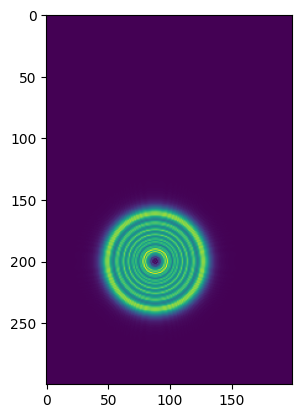

In [31]:
plt.imshow(netinputint1[450:750, 800:1000])

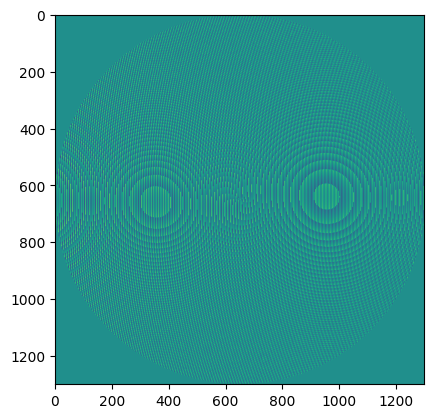

In [29]:
plt.imshow(inputphase1)

In [30]:
### Save progress
saver = np.zeros((1200,1920))
saver[0:1200,int(1920/2-sizepix/2):int(1920/2+sizepix/2)] = inputphase1[50:1250,:] / np.max(inputphase1[50:1250,:])*255
(Image.fromarray(saver).convert('RGB')).save(f"diffspace20_phaseretrieval_vortex1phase.bmp")
saver[0:1200,int(1920/2-sizepix/2):int(1920/2+sizepix/2)] = inputphase2[50:1250,:] / np.max(inputphase2[50:1250,:])*255
(Image.fromarray(saver).convert('RGB')).save(f"diffspace20_phaseretrieval_vortex2phase.bmp")
saver[0:1200,int(1920/2-sizepix/2):int(1920/2+sizepix/2)] = inputphase3[50:1250,:] / np.max(inputphase3[50:1250,:])*255
(Image.fromarray(saver).convert('RGB')).save(f"diffspace20_phaseretrieval_vortex3phase.bmp")


In [ ]:
unknownphase, errors1, errors2, ret_target1, ret_target2 = modifiedGWSalgo2tar(200, distortedtar1, distortedtar2, opticalvortexphase1, opticalvortexphase2,inputbeam, 500)

In [ ]:
unknownphase, errors1, errors2,errors3, ret_target1, ret_target2, rettarget3 = modifiedGWSalgo3tar(400,distortedtar1, distortedtar2, distortedtar3, opticalvortexphase1, opticalvortexphase2, opticalvortexphase3, inputbeam, 500)

In [ ]:
# plt.figure(figsize=(12,6))
# plt.subplot(1,1)
# plt.imshow(unknownphase - smooth_random_topology)
# plt.subplot(1,2)
# plt.imshow(smooth_random_topology)
# plt.show()
from scipy.ndimage import gaussian_filter
# plt.imshow(gaussian_filter(-unknownphase,sigma=15))
plt.imshow(unknownphase)
plt.colorbar()

In [ ]:
### Apply for camera based imaging


In [ ]:

def identify_tweezers(cameraimage, minintensity):
    ## This code assumes that the camera image is positioned s.t. the 0th order diffraction is centered vertically and just out of screen
    binary_camera_image = (cameraimage > minintensity).astype(np.uint8)
    labeled_camera_image, num_labels_camera = label(binary_camera_image)
    centers_camera = np.array(center_of_mass(binary_camera_image, labeled_camera_image, range(1, num_labels_camera + 1)))
    sorted_centers = centers_camera[np.lexsort((centers_camera[:, 1], centers_camera[:, 0]))]
    thanos_points = process(sorted_centers.tolist(), 50)

    center = np.mean(thanos_points, axis=0)
    # distances = np.linalg.norm(thanos_points - center, axis=1)
    # indices = np.argsort(distances)[-4:]
    # corners = thanos_points[indices]
    
    corners = thanos_points[np.argsort(thanos_points[:,0])]
    
    # perimeter = ConvexHull(sorted_centers) 
    # corners = sorted_centers[perimeter.vertices]
    return corners[np.argsort(corners[:,0])], center

from scipy.ndimage import affine_transform

def rotate_image(image, angle):
    # Calculate the rotation matrix
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle), np.cos(angle)]])

    # Calculate the translation needed to reposition the rotated image
    center = np.array(image.shape) // 2
    translation = center - np.dot(rotation_matrix, center)

    # Define the affine transformation matrix
    transformation_matrix = np.vstack([np.column_stack([rotation_matrix, translation]),
                                       [0, 0, 1]])

    # Apply the affine transformation to rotate the image
    rotated_image = affine_transform(image, transformation_matrix, mode='constant', cval=0)

    return rotated_image

from scipy.ndimage import zoom

def match_images(cameraimage, targetimage, intensity):
    camera_vertices = identify_tweezers(cameraimage, intensity)[0]
    angle = math.atan((camera_vertices[1,0]-camera_vertices[0,0])/(camera_vertices[1,1]-camera_vertices[0,1]))
    rotated_cameraimage = rotate_image(cameraimage, -angle)
    rotated_cameraimage_vertices = identify_tweezers(rotated_cameraimage, intensity)[0]
    targetimage_vertices, targetimage_center = identify_tweezers(targetimage, 1)

    height_target_rect = np.abs(targetimage_vertices[0,0] - targetimage_vertices[2,0])
    width_target_rect = np.abs(targetimage_vertices[0,1] - targetimage_vertices[1,1])
    height_camera_rect = np.abs(rotated_cameraimage_vertices[0,0] - rotated_cameraimage_vertices[2,0])
    width_camera_rect = np.abs(rotated_cameraimage_vertices[0,1] - rotated_cameraimage_vertices[1,1])

    height_scaling = height_target_rect / height_camera_rect
    width_scaling = width_target_rect / width_camera_rect
 
    scaled_camera_img = zoom(rotated_cameraimage, (height_scaling,width_scaling), mode='constant', cval = 0)
    scaled_camera_img_vertices, scaled_camera_center = identify_tweezers(scaled_camera_img, intensity)
 
    
    final_camera_img = np.zeros_like(targetimage)
    
    for y in range(np.shape(scaled_camera_img)[0]):
        for x in range(np.shape(scaled_camera_img)[1]):
            final_camera_img[y+(targetimage_center[0]-scaled_camera_center[0]).astype(np.int),x+(targetimage_center[1]-scaled_camera_center[1]).astype(np.int)] = scaled_camera_img[y,x]
    return final_camera_img, -angle, height_scaling, width_scaling, (targetimage_center[0]-scaled_camera_center[0]).astype(np.int), (targetimage_center[1]-scaled_camera_center[1]).astype(np.int)


def match_images_local(cameraimage, targetimage, params, scanradius):
    cameraimage = cameraimage
    targetimage = targetimage
    angle, Xmag, Ymag, Xshift, Yshift = params
    slave9 = rotate_image(cameraimage, angle)
    slave8 = scaleimg(slave9, Xmag, Ymag)
    master = np.zeros(np.shape(targetimage))
    original = shiftimage(slave8, targetimage, Xshift, Yshift)
    error = np.abs(np.sum(targetimage-original))
    for i in range(scanradius):
        for j in range(scanradius):
            slave_shifted = shiftimage(slave8, targetimage, Xshift - scanradius/2 + i, Yshift - scanradius/2 +j)
            errortemp = np.abs(np.sum(slave_shifted-targetimage))
            if errortemp < error:
                error = errortemp
                master = slave_shifted
    if np.sum(master) == 0:
        return original
    else:
        return master



def shiftimage(child1, parent, x_shift, y_shift):
    child_shape = np.shape(child1)
    parent_shape = np.shape(parent)
    fosterparent = np.zeros(parent_shape)
    x_shift = x_shift.astype(np.int)
    y_shift = y_shift.astype(np.int)
    fosterparent[x_shift:x_shift+child_shape[0], y_shift:y_shift+child_shape[1]] = child1
    return fosterparent

def scaleimg(child2, x_scaling, y_scaling):
    scaled_child = zoom(child2, (x_scaling, y_scaling), mode='constant', cval = 0)
    return scaled_child

    
    
def objectivefunction(params, child, parent):
    angle, Xmag, Ymag, Xshift, Yshift = params
    slave = rotate_image(child, angle)
    slave = scaleimg(slave, Xmag, Ymag)
    slave = shiftimage(slave, parent, Xshift, Yshift)
    
    error = np.abs(np.sum(slave-parent))
    return error


def find_weighted_center(image):
    # Create coordinate grids
    image = norm(image)
    image[image<0.3] = 0
    
    non_zero_coords = np.transpose(np.nonzero(image))
    if non_zero_coords.shape[0] > 0:
        average_coordinates = np.mean(non_zero_coords, axis=0)
        return tuple(average_coordinates.astype(int))
    else:
        return None


from PIL import Image

def tiff_to_bmp(input_path, output_path):
    # Open TIFF image
    tiff_image = Image.open(input_path)

    # Save as BMP
    tiff_image.save(output_path, 'BMP')
    
    
import cv2
import numpy as np

def match_and_paste(parent, child):
    # Convert images to grayscale
    parent_gray = cv2.cvtColor(parent, cv2.COLOR_BGR2GRAY)
    child_gray = cv2.cvtColor(child, cv2.COLOR_BGR2GRAY)

    # Use ORB (Oriented FAST and Rotated BRIEF) to find keypoints and descriptors
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(parent_gray, None)
    kp2, des2 = orb.detectAndCompute(child_gray, None)

    # Use BFMatcher to find the best matches between the descriptors
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Sort the matches based on their distances
    matches = sorted(matches, key=lambda x: x.distance)

    # Get the best match
    best_match = matches[0]

    # Get the keypoint coordinates for the parent and child
    parent_pts = np.float32([kp1[best_match.queryIdx].pt])
    child_pts = np.float32([kp2[best_match.trainIdx].pt])

    # Find the transformation matrix (rotation and scaling)
    M, _ = cv2.estimateAffinePartial2D(child_pts, parent_pts)

    # Apply the transformation to the child image
    child_transformed = cv2.warpAffine(child, M, (parent.shape[0], parent.shape[1]))

    return child_transformed


def identify_corners(cameraimage, targetimage, intensity):
    camera_vertices = identify_tweezers(cameraimage, intensity)[0]
    angle = math.atan((camera_vertices[1,0]-camera_vertices[0,0])/(camera_vertices[1,1]-camera_vertices[0,1]))
    rotated_cameraimage = rotate_image(cameraimage, -angle)
    rotated_cameraimage_vertices = identify_tweezers(rotated_cameraimage, intensity)[0]
    targetimage_vertices, targetimage_center = identify_tweezers(targetimage, 1)

    height_target_rect = np.abs(targetimage_vertices[0,0] - targetimage_vertices[2,0])
    width_target_rect = np.abs(targetimage_vertices[0,1] - targetimage_vertices[1,1])
    height_camera_rect = np.abs(rotated_cameraimage_vertices[0,0] - rotated_cameraimage_vertices[2,0])
    width_camera_rect = np.abs(rotated_cameraimage_vertices[0,1] - rotated_cameraimage_vertices[1,1])

    height_scaling = height_target_rect / height_camera_rect
    width_scaling = width_target_rect / width_camera_rect
 
    scaled_camera_img = zoom(rotated_cameraimage, (height_scaling,width_scaling), mode='constant', cval = 0)
    scaled_camera_img_vertices, scaled_camera_center = identify_tweezers(scaled_camera_img, intensity)
 
    
    corners_cameraimg = np.zeros_like(targetimage)
    # corners_cameraimg[int(targetimage_vertices[0,0]), int(targetimage_vertices[0,1])] = 255
    # corners_cameraimg[int(targetimage_vertices[1,0]), int(targetimage_vertices[1,1])] = 255
    # corners_cameraimg[int(targetimage_vertices[2,0]),int(targetimage_vertices[2,1])] = 255
    # corners_cameraimg[int(targetimage_vertices[3,0]),int(targetimage_vertices[3,1])] = 255
    corners_cameraimg[targetimage_vertices[0,0].astype(np.int), targetimage_vertices[0,1].astype(np.int)] = 255
    corners_cameraimg[targetimage_vertices[1,0].astype(np.int), targetimage_vertices[1,1].astype(np.int)] = 255
    corners_cameraimg[targetimage_vertices[2,0].astype(np.int),targetimage_vertices[2,1].astype(np.int)] = 255
    corners_cameraimg[targetimage_vertices[3,0].astype(np.int),targetimage_vertices[3,1].astype(np.int)] = 255
    return corners_cameraimg, -angle, height_scaling, width_scaling, (targetimage_center[0]-scaled_camera_center[0]).astype(np.int), (targetimage_center[1]-scaled_camera_center[1]).astype(np.int)

In [ ]:
#%%%%%%%%%%%%%%%%%%% LOAD MANUFACTURER PROGRAMS AND DLLS- START %%%%%%%%%%%%%%%%%%%%%%%%%

################################ MAKE SURE THE WINDOW SHOWS UP IN THE WRITE PLACE FOR THE DPI SETTINGS#############
# Query DPI Awareness (Windows 10 and 8)
import ctypes
import os
from ctypes import *
from scipy import misc
from time import sleep
import cv2
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from instrumental.drivers.cameras import uc480



awareness = ctypes.c_int()
errorCode = ctypes.windll.shcore.GetProcessDpiAwareness(0, ctypes.byref(awareness))
print(awareness.value)
# Set DPI Awareness  (Windows 10 and 8)
errorCode = ctypes.windll.shcore.SetProcessDpiAwareness(2)
# the argument is the awareness level, which can be 0, 1 or 2:
# for 1-to-1 pixel control I seem to need it to be non-zero (I'm using level 2)

# Set DPI Awareness  (Windows 7 and Vista)
success = ctypes.windll.user32.SetProcessDPIAware()
# behaviour on later OSes is undefined, although when I run it on my Windows 10 machine, it seems to work with effects identical to SetProcessDpiAwareness(1)
#######################################################################################################################
# Load the DLL
# Blink_C_wrapper.dll, HdmiDisplay.dll, ImageGen.dll, freeglut.dll and glew64.dll
# should all be located in the same directory as the program referencing the
# library
cdll.LoadLibrary("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\SDK\\Blink_C_wrapper")
slm_lib = CDLL("Blink_C_wrapper")

# Open the image generation library
cdll.LoadLibrary("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\SDK\\ImageGen")
image_lib = CDLL("ImageGen")
#%%%%%%%%%%%%%%%%%%% LOAD MANUFACTURER PROGRAMS dispup calibration settings %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# init camera
instruments = uc480.list_instruments()
cam = uc480.UC480_Camera(instruments[0])
# Start camera
cam.start_live_video(framerate = "10Hz")

print("Camera Loaded")

RGB = c_uint(1)
is_eight_bit_image = c_uint(0)
NumDataPoints = 10
NumRegions = 1 ## If we need regional calibration, set this to 64
slm_lib.Create_SDK(c_uint(1)) # Initialize SDK, c_unit(1) means true
print("Created SDK")

numFrames = 5
height = c_uint(slm_lib.Get_Height())
width = c_uint(slm_lib.Get_Width())
depth = c_uint(slm_lib.Get_Depth())
center_x = c_uint(width.value//2)
center_y = c_uint(height.value//2)

success = 0
success = slm_lib.Load_lut("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\LUT Files\\slmobjectiveglobal.lut")
print("Load LUT success")

In [ ]:
## NOW SHOW THE ANCHORS
anchors_phase_c = 0
anchors_slminput = 0
anchors_phases_1d = (anchors_phase.T).ravel().astype(np.uint8)
anchors_phases_c = np.empty(anchors_phases_1d.shape, dtype=np.uint8, order='C')
anchors_phases_c[:] = anchors_phases_1d
anchors_slminput = anchors_phases_c
slm_lib.Write_image(anchors_slminput.ctypes.data_as(POINTER(c_ubyte)), c_uint(1))
sleep(0.04)       
anchors_camera_test =  cam.grab_image(timeout='100s', copy=True, exposure_time = '2ms')
plt.imshow(anchors_camera_test)
plt.colorbar()
plt.show
